In [1]:
pip install pandas

In [2]:
pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from IPython.display import display, HTML

file_path = r"C:\\Users\\Chitra Vadlamani\Desktop\\portfolio_optimization\\company_stock_data.csv"
df = pd.read_csv(file_path)
display(HTML(df[["Company", "Symbol"]].to_html()))



,Company,Symbol
0,Microsoft Corp,MSFT
1,Apple Inc,AAPL
2,Amazon.com Inc,AMZN
3,Alphabet Inc,GOOG
4,NVIDIA Corp,NVDA


In [4]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libs                                                                                 
import os
import pandas as pd
import yfinance as yf

# Define some parameters                                                                                            
OUT_DIR = "data"
if not os.path.exists(OUT_DIR):
    # Create the directory
    os.makedirs(OUT_DIR)

DROP_STOCKS = []

# Get the list of all existing stocks                                                         
stocks = list(df["Symbol"].unique())

for stock in stocks:
    try:
        tmp_df = yf.Ticker(stock).history(
            period="max", interval="1d",
        )[["Close"]].rename(
            columns={
                "Close": stock,
            }
        )
        tmp_df["Date"] = tmp_df.index
        tmp_df.to_csv(
            os.path.join(OUT_DIR, "%s.csv" % stock),
            index=False,
        )
    except Exception as exc:
        print("Could not get price for %s" % stock)
        print(exc)
        DROP_STOCKS.append(stock)

    if tmp_df.shape[0] == 0:
        DROP_STOCKS.append(stock)

In [6]:
pip install --upgrade "qci-client<5"

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import libs                                                                                
import os
import sys
import time
import datetime
import json
import warnings
from functools import wraps
import numpy as np
import pandas as pd

from qci_client import QciClient

warnings.filterwarnings("ignore")

ALPHA = 1.0 # The coefficient for penalty term (for linear constraint)
N_SAMPLES = 5 # Number of solution samples
XI = 5.0 # The xi variable as defined in Methodology
K_PRIME = 3 # Number of selected stocks
WINDOW_DAYS = 30 # Size of each sliding window in days
WINDOW_OVERLAP_DAYS = 15 # Overlap between sliding windows in days
IN_SAMPLE_DAYS = 180 # Size of the lookback period in days
OUT_OF_SAMPLE_DAYS = 30 # Size of the horizon window in days

In [8]:
def get_stock_returns(stocks, min_date, max_date):

    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    return_df = None

    for stock in stocks:
        file_path = r"C:\\Users\\Chitra Vadlamani\Desktop\\portfolio_optimization\data/%s.csv" % stock
        stock_df = pd.read_csv(file_path)
        #stock_df = pd.read_csv("data/%s.csv" % stock)
        #stock_df["Date"] = stock_df["Date"].astype("datetime64[ns]") # change to fix timezone issue
        stock_df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in stock_df["Date"]])  
        stock_df = stock_df.fillna(method="ffill").fillna(method="bfill")
        stock_df[stock] = stock_df[stock].pct_change()
        stock_df = stock_df.dropna()

        stock_df = stock_df[
            (stock_df["Date"] >= min_date) & (stock_df["Date"] <= max_date)
        ]
        
        if return_df is None:
            return_df = stock_df
        else:
            return_df = return_df.merge(stock_df, how="outer", on="Date",)

    return_df = return_df.fillna(method="ffill").fillna(method="bfill")

    return return_df

In [9]:
def get_hamiltonian(
    return_df, stocks, min_date, max_date,
):

    K = len(stocks)

    # Calculate P and Q                                                                       
    Q = np.zeros(shape=(K, K), dtype="d")
    P = np.zeros(shape=(K, K), dtype="d")
    m = 0
    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    tmp_date = min_date
    while tmp_date <= max_date:
        tmp_min_date = tmp_date
        tmp_max_date = tmp_date + datetime.timedelta(days=WINDOW_DAYS)
        tmp_df = return_df[
            (return_df["Date"] >= tmp_min_date)
            & (return_df["Date"] <= tmp_max_date)
        ]
        r_list = []
        for i in range(K):
            r_list.append(np.array(tmp_df[stocks[i]]))

        Q += np.cov(r_list)

        for i in range(K):
            for j in range(K):
                P[i][j] += np.mean(r_list[i]) * np.mean(r_list[j])

        tmp_date += datetime.timedelta(
            days=WINDOW_DAYS - WINDOW_OVERLAP_DAYS,
        )
        m += 1

    fct = m
    if fct > 0:
        fct = 1.0 / fct

    P = fct * P
    Q = fct * Q

    # Calculate the Hamiltonian                                                              
    H = -P + XI * Q

    # make sure H is symmetric up to machine precision                                       
    H = 0.5 * (H + H.transpose())

    return H

In [10]:
def optimize_portfolio(H, stocks, curr_date):

    beg_time = time.time()

    K = len(stocks)

    assert H.shape[0] == K
    assert H.shape[1] == K

    # Generate the constraint                                                                
    cons_lhs = np.ones(shape=(K), dtype=np.float32)
    cons_rhs = np.array([-K_PRIME])

    constraints = np.hstack([cons_lhs, cons_rhs])

    # Create json objects   
    objective_json = {
        "file_name": "objective_tutorial_eq_wt_port_opt.json",
        "file_config": {
            "objective": {"data": H, "num_variables": K},
        }  
    }
    
    constraint_json = {
        "file_name": "constraints_tutorial_eq_wt_port_opt.json",
        "file_config": {
            "constraints": {
                "data": constraints, 
                 "num_variables": K,
                 "num_constraints": 1,
            }
        }
    }

    job_json = {
        "job_name": "moodys_eqc1_equal_weights",
        "job_tags": ["moody_nasda100_eqc1_equal_weights",],
        "params": {
            "device_type": "csample", #"eqc1",                                               
            "num_samples": N_SAMPLES,
            "alpha": ALPHA,
        },
    }

    # Solve the optimization problem
    token = "8982feb60ad44ce68ba981ad7a9970b7"
    api_url = "https://api.qci-prod.com"
    qci = QciClient(api_token=token, url=api_url)

    response_json = qci.upload_file(file=objective_json)
    objective_file_id = response_json["file_id"]

    response_json = qci.upload_file(file=constraint_json)
    constraint_file_id = response_json["file_id"]

    job_params = {
        "device_type": "dirac-1", 
        "alpha": ALPHA, 
        "num_samples": N_SAMPLES,
    }
    
    job_json = qci.build_job_body(
        job_type="sample-constraint", 
        job_params=job_params,
        constraints_file_id=constraint_file_id, 
        objective_file_id=objective_file_id,
        job_name=f"tutorial_eqc1",
        job_tags=["tutorial_eqc1"],
    )
    print(job_json)
    
    job_response_json = qci.process_job(
        job_body=job_json
    )

    print(job_response_json)

    results = job_response_json["results"]
    energies = results["energies"]
    samples = results["solutions"]
    is_feasibles = results["feasibilities"]

    # The sample solutions are sorted by energy                                               
    sol = None
    for i, item in enumerate(samples):
        sol = item
        is_feasible = is_feasibles[i]

        if is_feasible:
            break

    if not is_feasible:
        print("Solution is not feasible!")

    assert len(sol) == K, "Inconsistent solution size!"

    if sum(sol) != K_PRIME:
        print(
            "Expected to select %d stocks, but selected %d!"
            % (K_PRIME, sum(sol))
	)

    sel_stocks = []
    for i in range(K):
        if sol[i] > 0:
            sel_stocks.append(stocks[i])

    print(
        "In optimize_portfolio; done with checking constraints; %0.2f seconds!"
        % (time.time() - beg_time)
    )

    return sol, sel_stocks

In [11]:
def run(curr_date):

    print("Processing curr date:", curr_date)

    curr_date = pd.to_datetime(curr_date)
    min_ins_date = curr_date - datetime.timedelta(days=IN_SAMPLE_DAYS)
    max_ins_date = curr_date - datetime.timedelta(days=1)
    min_oos_date = curr_date
    max_oos_date = curr_date + datetime.timedelta(days=OUT_OF_SAMPLE_DAYS)

    file_path = r"C:\\Users\\Chitra Vadlamani\Desktop\\portfolio_optimization\\company_stock_data.csv"
    df = pd.read_csv(file_path)

    stocks = list(set(df["Symbol"]) - set(DROP_STOCKS))

    ins_return_df = get_stock_returns(stocks, min_ins_date, max_ins_date)
    oos_return_df = get_stock_returns(stocks, min_oos_date, max_oos_date)

    ins_return_df = ins_return_df.sort_values("Date")
    ins_return_df = ins_return_df.fillna(method="ffill").fillna(0)

    oos_return_df = oos_return_df.sort_values("Date")
    oos_return_df = oos_return_df.fillna(method="ffill").fillna(0)

    H = get_hamiltonian(ins_return_df, stocks, min_ins_date, max_ins_date)

    sol, sel_stocks = optimize_portfolio(H, stocks, curr_date)

    sel_stock_df = pd.DataFrame()
    sel_stock_df["Date"] = [curr_date] * len(sel_stocks)
    sel_stock_df["Stock"] = sel_stocks

    return sel_stock_df

In [12]:
min_date = pd.to_datetime("2022-01-13")                                    
max_date = pd.to_datetime("2022-04-30")

SEL_STOCK_OUT_FILE = "selected_stocks.csv"

curr_date = min_date
while curr_date < max_date:
    tmp_sel_stock_df = run(curr_date)

    if os.path.exists(SEL_STOCK_OUT_FILE):
        tmp_sel_stock_df.to_csv(
            SEL_STOCK_OUT_FILE, index=False, mode="a", header=False,
        )
    else:
        tmp_sel_stock_df.to_csv(
            SEL_STOCK_OUT_FILE, index=False,
        )

    curr_date += datetime.timedelta(days=OUT_OF_SAMPLE_DAYS + 1)

Processing curr date: 2022-01-13 00:00:00
{'job_submission': {'problem_config': {'quadratic_linearly_constrained_binary_optimization': {'constraints_file_id': '666c840e98263204a365d9e3', 'objective_file_id': '666c840e98263204a365d9e1', 'alpha': 1.0}}, 'device_config': {'dirac-1': {'num_samples': 5}}, 'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1']}}
2024-06-14 13:55:26 - Dirac allocation balance = 0 s (unmetered)
2024-06-14 13:55:26 - Job submitted: job_id='666c840fa3e6a645a5c4e6f5'
2024-06-14 13:55:27 - QUEUED
2024-06-14 13:55:29 - RUNNING
2024-06-14 13:56:34 - COMPLETED
2024-06-14 13:56:37 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '666c840fa3e6a645a5c4e6f5', 'job_submission': {'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1'], 'problem_config': {'quadratic_linearly_constrained_binary_optimization': {'constraints_file_id': '666c840e98263204a365d9e3', 'objective_file_id': '666c840e98263204a365d9e1', 'alpha': 1, 'atol': 1e-10}}, 'device_con

In [13]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Import libs                                                                                 
import sys
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Set params                                                                                  
INIT_PORT_VAL = 1000000.0
OUT_OF_SAMPLE_DAYS = 30
K_PRIME = 30
XI = 5.0


SEL_STOCK_FILE = "selected_stocks.csv"


MIN_DATE = pd.to_datetime("2022-01-01")
MAX_DATE = pd.to_datetime("2022-12-31")

# Read allocation file                                                                        
df = pd.read_csv(SEL_STOCK_FILE)
#df["Date"] = df["Date"].astype("datetime64[ns]")
df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in df["Date"]])
df = df[(df["Date"] >= MIN_DATE) & (df["Date"] <= MAX_DATE)]

# Loop through dates and calculate port value                                                 
beg_port_val = INIT_PORT_VAL
df = df.sort_values("Date")
adj_dates = sorted(df["Date"].unique())
num_adj_dates = len(adj_dates)
dates = None
port_vals = None
for i in range(num_adj_dates):

    print(
        "Processing adjustment date %s"
        % pd.to_datetime(adj_dates[i]).strftime("%Y-%m-%d")
    )

    beg_date = pd.to_datetime(adj_dates[i])
    if i < num_adj_dates - 1:
        end_date = pd.to_datetime(adj_dates[i + 1])
    else:
        end_date = beg_date + datetime.timedelta(days=OUT_OF_SAMPLE_DAYS)

    tmp_df = df[df["Date"] == beg_date]
    stocks = tmp_df["Stock"]
    stocks = list(set(stocks))

    stocks = list(set(stocks) - set(DROP_STOCKS) - {"FISV"})
    
    if end_date > pd.to_datetime("2023-10-20"):
        stocks = list(set(stocks) - {"ATVI"})

    all_dates = [beg_date]
    date0 = beg_date
    while date0 < end_date:
        date0 = date0 + datetime.timedelta(days=1)
        all_dates.append(date0)

    price_df = pd.DataFrame({"Date": all_dates})

    for stock in stocks:
        stock_df = pd.read_csv("data/%s.csv" % stock)
        #stock_df["Date"] = stock_df["Date"].astype("datetime64[ns]")
        stock_df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in stock_df["Date"]])
        stock_df = stock_df[
            (stock_df["Date"] >= beg_date) & (stock_df["Date"] <= end_date)
        ]

        if price_df is None:
            price_df = stock_df
        else:
            price_df = price_df.merge(stock_df, on="Date", how="outer")

    price_df = price_df.fillna(method="ffill").fillna(method="bfill")
    price_df = price_df.sort_values("Date")

    tmp_dates = np.array(price_df["Date"])
    tmp_port_vals = np.zeros(shape=(price_df.shape[0]))

    assert price_df.shape[0] > 0

    for stock in stocks:
        prices = np.array(price_df[stock])
        beg_price = prices[0]
        stock_wt = 1.0 / len(stocks)

        if beg_price <= 0:
            print(stock)
            print(price_df[["Date", stock]])
            
        assert beg_price > 0, "Error in data for %s" % stock # this assertion was failing, when I comment it out we get all NaN values

        stock_count = stock_wt * beg_port_val / beg_price
        tmp_port_vals += stock_count * prices

    if dates is None:
        dates = tmp_dates
    else:
        dates = np.concatenate([dates, tmp_dates])

    if port_vals is None:
        port_vals = tmp_port_vals
    else:
        port_vals = np.concatenate([port_vals, tmp_port_vals])

    beg_port_val = port_vals[-1]

Processing adjustment date 2022-01-13
Processing adjustment date 2022-02-13
Processing adjustment date 2022-03-16
Processing adjustment date 2022-04-16


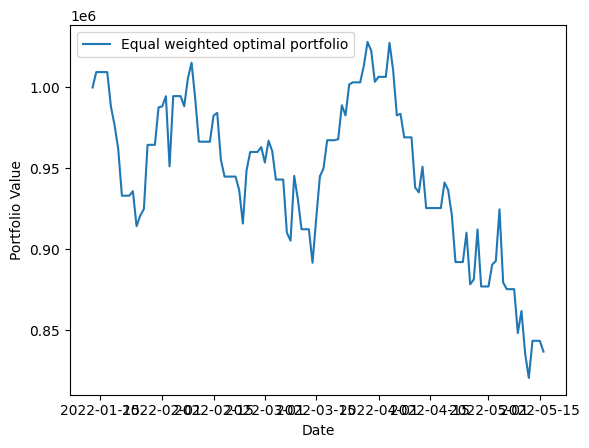

In [15]:
# note these are the results when the beg price assertion from the previous cell was commented, turn into all NaN values
# Plot    
out_df = pd.DataFrame({"Date": dates, "Port_Val": port_vals})
out_df["Date"] = out_df["Date"].astype("datetime64[ns]")
plt.plot(
    out_df["Date"], out_df["Port_Val"]                                            
)
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

plt.legend(
    [
        "Equal weighted optimal portfolio"
    ]
)                                 
plt.show()